# imports

In [131]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler
import numpy as np

import glob
import os

import lal
import lalsimulation as lalsim

import utils

<Figure size 432x288 with 0 Axes>

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [132]:
import pycbc.pnutils

In [133]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy import optimize

In [134]:
import phenom

import lmfit
from lmfit import Minimizer, Parameters, report_fit

# helpers

In [135]:
def sech(x):
    return 1/np.cosh(x)

In [136]:
def make_nr_dict(root_dir):
    """
    makes a dictionary of paths to NR files
    with multiple resolutions
    """
    nr_ids = dict(q1="180", q2="169", q4="167", q5="107", q10="303")

    nrfiles = {}

    for key, val in nr_ids.items():
        ps = glob.glob(os.path.join(root_dir, "*" + val + "*.h5"))

        nrfiles.update({key: {}})
        for p in ps:
            k = p.split("/")[-1].split(".h5")[0].split("_")[-1]
            nrfiles[key].update({k: p})

    return nrfiles

In [137]:
def gen_model_waveform(approx, q, npts):
    lal_approx = lalsim.GetApproximantFromString(approx)
    return utils.WaveformGeneration(approximant=lal_approx, q=q, npts=npts)

In [138]:
def get_t_of_f(t, f, f0):
    """
    use this to find the time at which a frequency f0 occures
    """
    # only look at times before peak because NR data can result
    # non-monotonic function due to noise in the ringdown
    mask = t < 0
    iy = IUS(t[mask], f[mask]-f0)
    
    sol = optimize.root(iy, 0, method='hybr')
    return sol.x[0]

In [139]:
def d_arcsinh_dx(x, a, power=0):
    if power == 0:
        return 0*x
    else:
        return a / np.sqrt(np.power(a*x,2)+1) * (power * np.arcsinh(a*x)**(power-1))
    
    
    
def d2_arcsinh_d2x(x, a, power=0):
    # 2nd derivative of arcsinh(a*x)^power
    if power == 0:
        return 0*x
    else:
        
        a2 = a*a
        ax = a*x
        ax2 = ax*ax
        ax2_p_1 = ax2 + 1
        
        sqrt_ax2_p_1 = np.sqrt(ax2_p_1)
        ax2_p_1_pow_3_over_2 = np.power(ax2_p_1, 3./2.)
        
        if power == 1:
            num = -a2*ax
            den = ax2_p_1_pow_3_over_2
            return num / den
        elif power == 2:
            num = 2*a2*(sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = sqrt_ax2_p_1
            return num / den
        elif power == 3:
            num = 3*a2*np.arcsinh(ax) * (2*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 4:
            num = 4*a2*np.arcsinh(ax) * (3*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 5:
            num = 5*a2*np.arcsinh(ax) * (4*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 6:
            num = 6*a2*np.arcsinh(ax) * (5*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 7:
            num = 7*a2*np.arcsinh(ax) * (6*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 8:
            num = 8*a2*np.arcsinh(ax) * (7*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 9:
            num = 9*a2*np.arcsinh(ax) * (8*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den
        elif power == 10:
            num = 10*a2*np.arcsinh(ax) * (9*sqrt_ax2_p_1 - ax*np.arcsinh(ax))
            den = ax2_p_1_pow_3_over_2
            return num/den

# fit functions

In [140]:
class Collocation_Model_Amp_Int(object):
    """
    """
    def __init__(self, x, y, q, c_points, d1_c_points=None, d2_c_points=None):
        self.x = x
        self.y = y
        
        self.q = q
        self.eta = phenom.eta_from_q(self.q)
        
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        
        self.a1 = self.fdamp * 2 * np.pi
        
        self.c_points = np.array(c_points, dtype=np.float32)
        self.n_coeffs_d0 = len(self.c_points)
        if d1_c_points is not None:
            self.d1_c_points = np.array(d1_c_points, dtype=np.float32)
            self.n_coeffs_d1 = len(self.d1_c_points)
        else:
            self.n_coeffs_d1 = 0
        if d2_c_points is not None:
            self.d2_c_points = np.array(d2_c_points, dtype=np.float32)
            self.n_coeffs_d2 = len(self.d2_c_points)
        else:
            self.d2_c_points = None
            self.n_coeffs_d2 = 0
        
        self.n_coeffs = self.n_coeffs_d0 + self.n_coeffs_d1 + self.n_coeffs_d2
        
        self.create_information_matrix()
        
        self.first_time = True
        
    def basis(self, t):
        a1 = self.a1
        
        basis = np.array([np.power(np.arcsinh(a1*t), i) for i in range(self.n_coeffs)])
        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])

        return basis

    def basis_1st_deriv(self, t):
        a1 = self.a1
        
        basis = np.array([d_arcsinh_dx(t, a1, power=i) for i in range(self.n_coeffs)])

        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])

        return basis
    
    def basis_2nd_deriv(self, t):
        a1 = self.a1
        
        basis = np.array([d2_arcsinh_d2x(t, a1, power=i) for i in range(self.n_coeffs)])
        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])
        
        return basis
    
    def create_information_matrix(self):
        """
        val_c_points: list of times to build equations constraining the value of the function
        deriv_c_points: list of times to build equations constraining the 1st derivative value of the function
        """
        val_c_points = self.c_points
        deriv_c_points = self.d1_c_points
        deriv_2_c_points = self.d2_c_points
        
        if val_c_points is not None:
            A_val = self.basis(val_c_points)
        if deriv_c_points is not None:
            A_1st_deriv = self.basis_1st_deriv(deriv_c_points)
        if deriv_2_c_points is not None:
            A_2nd_deriv = self.basis_2nd_deriv(deriv_2_c_points)
        # output shape: (num equations, num coeffs)
        
        if val_c_points  is not None and deriv_c_points  is not None and deriv_2_c_points is not None:
            self.information_matrix = np.column_stack((A_val, A_1st_deriv, A_2nd_deriv)).T
            return 
        if val_c_points  is not None and deriv_c_points  is not None:
            self.information_matrix = np.column_stack((A_val, A_1st_deriv)).T
            return 
        if val_c_points is not None:
            self.information_matrix = A_val.T
            return 
        # if deriv_c_points is not None:
        #     return A_1st_deriv.T
        # if deriv_2_c_points is not None:
        #     return A_2nd_deriv.T
        
        
    def eval_rhs(self, f):
        """
        evaluate rhs given rhs function `f` at collocation points and derivs
        """
        y0 = f(self.c_points)
        if self.d1_c_points is not None:
            y1 = f.derivative()(self.d1_c_points)
            y0 = np.concatenate((y0, y1))
        if self.d2_c_points is not None:
            y2 = f.derivative(2)(self.d2_c_points)
            y0 = np.concatenate((y0, y2))
        # self.rhs = y0
        self.set_rhs(y0)
                
    def set_rhs(self, rhs):
        """
        right hand side of linear system of equations
        """
        self.rhs = rhs
        if self.first_time:
            self.og_rhs = rhs.copy()
            self.first_time = False
        
    def reset_rhs(self):
        self.rhs = self.og_rhs
    
    def fit(self):
        self.coeffs = np.linalg.solve(self.information_matrix, self.rhs)
    
    def predict(self, t, noise=None):
        if noise is not None:
            self.reset_rhs()
            # noise = np.random.normal(0, noise, size=self.n_coeffs)
            self.set_rhs(self.rhs + noise)
            self.fit()
        else:
            # inefficient but safe
            self.reset_rhs()
            self.fit()
        b = self.basis(t)
        return np.dot(self.coeffs, b)

In [141]:
def rd_ansatz(t, a, b):
    return a * np.exp(-t*b)

In [142]:
def rd_ansatz_log(t, a, b):
    return np.log(a) - t*b

In [143]:
def connect_rd(t0, y0, fdamp):
    """
    y0 == y(t0)
    this is just fixing the constant offset between the phenom model from peak amplitude
    to about t0=30M.
    We assume the slope is given by the approximately known damping frequency
    We assume exponential decay so it's linear in log-space
    """
    b = fdamp*2*np.pi
    log_a = np.log(y0) + b * t0
    return np.exp(log_a), b

In [144]:
class Collocation_Model_Amp_Ringdown(object):
    """
    """
    def __init__(self, x, y, q, c_points, d1_c_points=None, d2_c_points=None):
        self.x = x
        self.y = y
        
        self.q = q
        self.eta = phenom.eta_from_q(self.q)
        
        self.fin_spin = phenom.remnant.FinalSpin0815(self.eta, 0, 0)
        self.fring = phenom.remnant.fring(self.eta, 0, 0, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(self.eta, 0, 0, self.fin_spin)
        
        self.a1 = self.fdamp * 2 * np.pi
        
        self.c_points = np.array(c_points, dtype=np.float32)
        self.n_coeffs_d0 = len(self.c_points)
        if d1_c_points is not None:
            self.d1_c_points = np.array(d1_c_points, dtype=np.float32)
            self.n_coeffs_d1 = len(self.d1_c_points)
        else:
            self.n_coeffs_d1 = 0
        if d2_c_points is not None:
            self.d2_c_points = np.array(d2_c_points, dtype=np.float32)
            self.n_coeffs_d2 = len(self.d2_c_points)
        else:
            self.d2_c_points = None
            self.n_coeffs_d2 = 0
        
        self.n_coeffs = self.n_coeffs_d0 + self.n_coeffs_d1 + self.n_coeffs_d2
        
        self.create_information_matrix()
        
        self.first_time = True
        
    def basis(self, t):
        a1 = self.a1
        
        basis = np.array([np.power(np.arcsinh(a1*t), i) for i in range(self.n_coeffs)])
        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])

        return basis

    def basis_1st_deriv(self, t):
        a1 = self.a1
        
        basis = np.array([d_arcsinh_dx(t, a1, power=i) for i in range(self.n_coeffs)])

        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])

        return basis
    
    def basis_2nd_deriv(self, t):
        a1 = self.a1
        
        basis = np.array([d2_arcsinh_d2x(t, a1, power=i) for i in range(self.n_coeffs)])
        # basis = np.array([np.power((a1*t), i) for i in range(self.n_coeffs)])
        
        return basis
    
    def create_information_matrix(self):
        """
        val_c_points: list of times to build equations constraining the value of the function
        deriv_c_points: list of times to build equations constraining the 1st derivative value of the function
        """
        val_c_points = self.c_points
        deriv_c_points = self.d1_c_points
        deriv_2_c_points = self.d2_c_points
        
        if val_c_points is not None:
            A_val = self.basis(val_c_points)
        if deriv_c_points is not None:
            A_1st_deriv = self.basis_1st_deriv(deriv_c_points)
        if deriv_2_c_points is not None:
            A_2nd_deriv = self.basis_2nd_deriv(deriv_2_c_points)
        # output shape: (num equations, num coeffs)
        
        if val_c_points  is not None and deriv_c_points  is not None and deriv_2_c_points is not None:
            self.information_matrix = np.column_stack((A_val, A_1st_deriv, A_2nd_deriv)).T
            return 
        if val_c_points  is not None and deriv_c_points  is not None:
            self.information_matrix = np.column_stack((A_val, A_1st_deriv)).T
            return 
        if val_c_points is not None:
            self.information_matrix = A_val.T
            return 
        # if deriv_c_points is not None:
        #     return A_1st_deriv.T
        # if deriv_2_c_points is not None:
        #     return A_2nd_deriv.T
        
        
    def eval_rhs(self, f):
        """
        evaluate rhs given rhs function `f` at collocation points and derivs
        """
        self.f = f
        y0 = f(self.c_points)
        if self.d1_c_points is not None:
            y1 = f.derivative()(self.d1_c_points)
            y0 = np.concatenate((y0, y1))
        if self.d2_c_points is not None:
            y2 = f.derivative(2)(self.d2_c_points)
            y0 = np.concatenate((y0, y2))
        # self.rhs = y0
        self.set_rhs(y0)
        
        
    def set_rhs(self, rhs):
        """
        right hand side of linear system of equations
        """
        self.rhs = rhs
        if self.first_time:
            self.og_rhs = rhs
            self.first_time = False
        
    def reset_rhs(self):
        self.rhs = self.og_rhs
    
    
    def fit(self):
        self.coeffs = np.linalg.solve(self.information_matrix, self.rhs)
        
        

    def predict(self, t, t0=30, noise=None):
        """
        t0 == transition to exponential ringdown
        """
        if noise is not None:
            self.reset_rhs()
            # noise = np.random.normal(0, noise, size=self.n_coeffs)
            self.set_rhs(self.rhs + noise)
            self.fit()
        else:
            # inefficient but safe
            self.reset_rhs()
            self.fit()
        
        y = np.zeros_like(t)
        
        mask = t < t0
        b = self.basis(t[mask])
        y[mask] = np.dot(self.coeffs, b)
        
        
        a, b = connect_rd(t0=t0, y0=self.f(t0), fdamp=self.fdamp)
        y[~mask] = np.exp(rd_ansatz_log(t[~mask], a, b))
        return y

# config

In [145]:
# root_dir = "/Users/spx8sk/work/data"
# root_dir = "/Volumes/ancient/mirror/machines/CU_mbp/work/data"
root_dir = "/Users/sebastian.khan/personal/data"

npts = 5000

mtot=1

# mass-ratio key
q = 1
q_key = f'q{q}'

m1, m2 = phenom.m1_m2_M_q(mtot, q)
meco_frequency = phenom.HztoMf(pycbc.pnutils.meco_frequency(m1,m2, 0, 0), mtot)*2*np.pi
hybrid_meco_frequency = phenom.HztoMf(pycbc.pnutils.hybrid_meco_frequency(m1, m2, 0, 0), 1)*2*np.pi

print(f"{meco_frequency = }")
print(f"{hybrid_meco_frequency = }")

# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomC", "IMRPhenomB"]
approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomT", "TEOBResumS"]
# approxs = ["SEOBNRv4_opt", "IMRPhenomD", "IMRPhenomT", "TEOBResumS", "IMRPhenomC", "IMRPhenomB"]

# to_model = 'amp'
# to_model = 'phase'
# to_model = 'freq'

# get data
nrfiles = dict(
    q1=os.path.join(root_dir, "SXS_BBH_0180_Res4.h5"),
    q2=os.path.join(root_dir, "SXS_BBH_0169_Res5.h5"),
    q4=os.path.join(root_dir, "SXS_BBH_0167_Res5.h5"),
    q5=os.path.join(root_dir, "SXS_BBH_0107_Res5.h5"),
    q10=os.path.join(root_dir, "SXS_BBH_0303_Res5.h5"),
    q18=os.path.join(root_dir, "q18a0a0c025_144-22-hybrid.h5"),
)

meco_frequency = 0.2574670024487408
hybrid_meco_frequency = 0.15396662670493216


In [146]:
# nrfiles = make_nr_dict(root_dir)
# nrfiles

# generate data

In [147]:
target_wf = utils.WaveformGeneration(nrfile=nrfiles[q_key], npts=npts)

In [148]:
target_wf

In [149]:
# estimate time of meco
t_meco = get_t_of_f(target_wf.times, target_wf.freq, -meco_frequency)
t_meco

-12.000190540863667

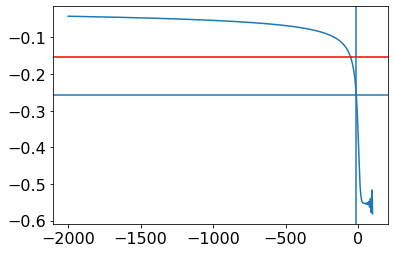

In [150]:
plt.plot(target_wf.times, target_wf.freq)
plt.axhline(-meco_frequency)
plt.axhline(-hybrid_meco_frequency, c='r')
plt.axvline(t_meco)

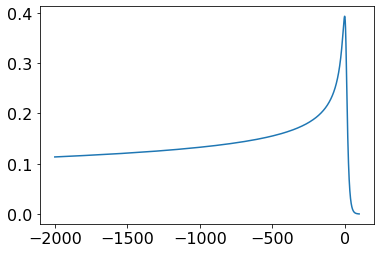

In [151]:
plt.plot(target_wf.times, target_wf.amp)

(-100.0, 205.0)

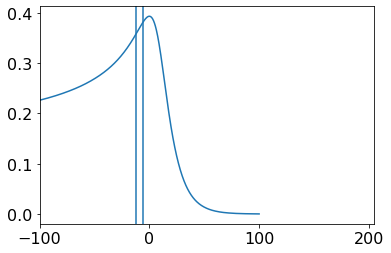

In [152]:
plt.plot(target_wf.times, target_wf.amp)
plt.axvline(t_meco)
plt.axvline(t_meco*0.5)
plt.xlim(-100)

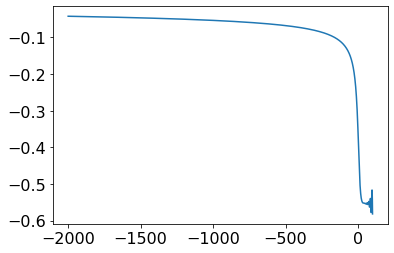

In [153]:
plt.plot(target_wf.times, target_wf.freq)

# amplitude merger model

In [154]:
amp_merger_model = Collocation_Model_Amp_Int(
    target_wf.times,
    target_wf.amp,
    # target_wf.freq,
    q,
    # c_points=[4*t_meco, 2*t_meco, t_meco, 0],
    # d1_c_points=[4*t_meco, 0],
    c_points=[-100, -50, -25, 0],
    d1_c_points=[-100, 0],
    # d2_c_points=[0]
    d2_c_points=None
)

In [155]:
amp_merger_model.n_coeffs

6

In [156]:
i_amp = IUS(target_wf.times, target_wf.amp)
# i_amp = IUS(target_wf.times, target_wf.freq)

In [157]:
amp_merger_model.eval_rhs(i_amp)

In [158]:
amp_merger_model.rhs

array([ 2.26150171e-01,  2.68883703e-01,  3.16232660e-01,  3.93139443e-01,
        5.58133719e-04, -1.87039295e-08])

In [159]:
amp_merger_model.fit()

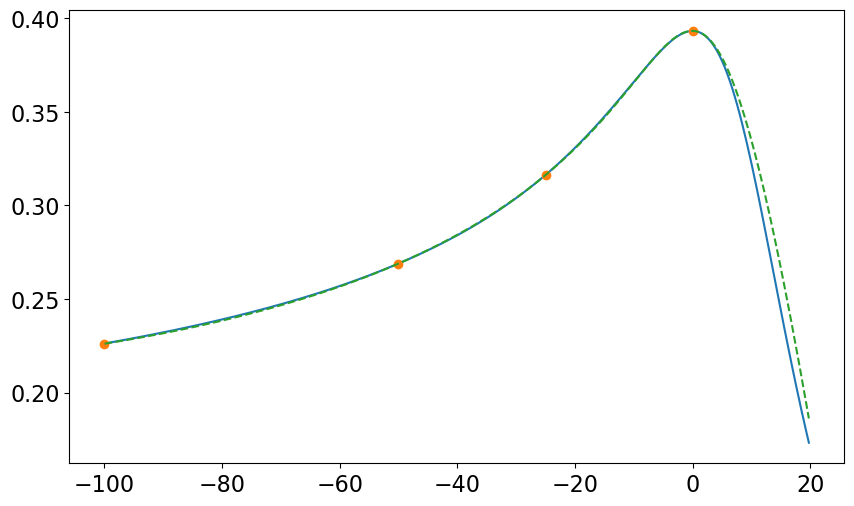

In [160]:
plt.figure(figsize=(10, 6), dpi=100)
mask = (target_wf.times > -100) & (target_wf.times < 20)
plt.plot(target_wf.times[mask], target_wf.amp[mask])

plt.plot(amp_merger_model.c_points, amp_merger_model.predict(amp_merger_model.c_points), 'o')

# plt.plot(target_wf.times[mask], amp_merger_model.predict(target_wf.times, noise=np.random.normal(0, 0.001))[mask], ls='--')
# plt.plot(target_wf.times[mask], amp_merger_model.predict(target_wf.times, noise=0.0001)[mask], ls='--')

noise_sd = 0.0001
noise = np.random.normal(0, noise_sd, size=amp_merger_model.n_coeffs)
plt.plot(target_wf.times[mask], amp_merger_model.predict(target_wf.times, noise=noise)[mask], ls='--')

            

# plt.xlim(-200, 10)

# amplitude ringdown model

In [161]:
amp_ringdown_model = Collocation_Model_Amp_Ringdown(
    target_wf.times,
    target_wf.amp,
    # target_wf.freq,
    q,
    # c_points=[4*t_meco, 2*t_meco, t_meco, 0],
    # d1_c_points=[4*t_meco, 0],
    c_points=[0, 5, 20, 30],
    d1_c_points=[0, 20, 30],
    # d2_c_points=[0]
    d2_c_points=[0]
)

In [162]:
amp_ringdown_model.n_coeffs

8

In [163]:
# i_amp = IUS(target_wf.times, target_wf.amp)

In [164]:
amp_ringdown_model.eval_rhs(i_amp)

In [165]:
amp_ringdown_model.rhs

array([ 3.93139443e-01,  3.77147955e-01,  1.70087444e-01,  7.53157753e-02,
       -1.87039295e-08, -1.30839005e-02, -6.36600751e-03, -1.00541371e-03])

In [166]:
amp_ringdown_model.fit()

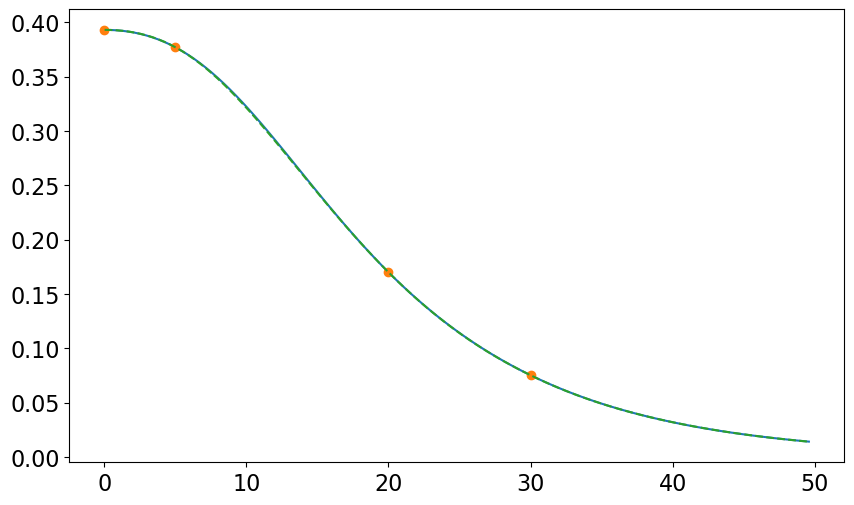

In [167]:
plt.figure(figsize=(10, 6), dpi=100)
mask = (target_wf.times > 0) & (target_wf.times < 50)
plt.plot(target_wf.times[mask], target_wf.amp[mask])
# plt.plot(target_wf.times[mask], target_wf.freq[mask])

plt.plot(amp_ringdown_model.c_points, amp_ringdown_model.predict(amp_ringdown_model.c_points, t0=30), 'o')

plt.plot(target_wf.times[mask], amp_ringdown_model.predict(target_wf.times, t0=30)[mask], ls='--')
# plt.xlim(-200, 10)
# plt.yscale('log')

In [168]:
def mrd_model(times, m_model, rd_model, t0=0., noise_m=0, noise_rd=0):
    y = np.zeros_like(times)
    mask = times < t0
    
#     t1 = times[mask]
#     t2 = times[~mask]
  
#     y1 = m_model.predict(t1, noise)
#     y2 = rd_model.predict(t2, 30, noise)
    

    # return t1, t2, y1, y2


    y[mask] = m_model.predict(times[mask], noise=noise_m)
    y[~mask] = rd_model.predict(times[~mask], t0=30, noise=noise_rd)
    

    return np.concatenate((times[mask], times[~mask])), y

In [169]:
x_tst = np.linspace(0, 50., 100)

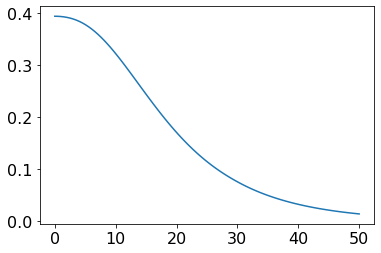

In [170]:
plt.plot(x_tst, amp_ringdown_model.predict(x_tst))

In [171]:
# t1, t2, y1, y2 = mrd_model(np.linspace(-100, 50., 100), amp_merger_model, amp_ringdown_model, 1, noise=0.001)
# plt.plot(t1, y1)
# plt.plot(t2, y2)
# plt.plot(x_tst, amp_ringdown_model.predict(x_tst))
# plt.plot(t2, amp_ringdown_model.predict(t2))
# plt.yscale('log')

Text(0.5, 1.0, 'uncorrelated/independent RHS noise at collocation points')

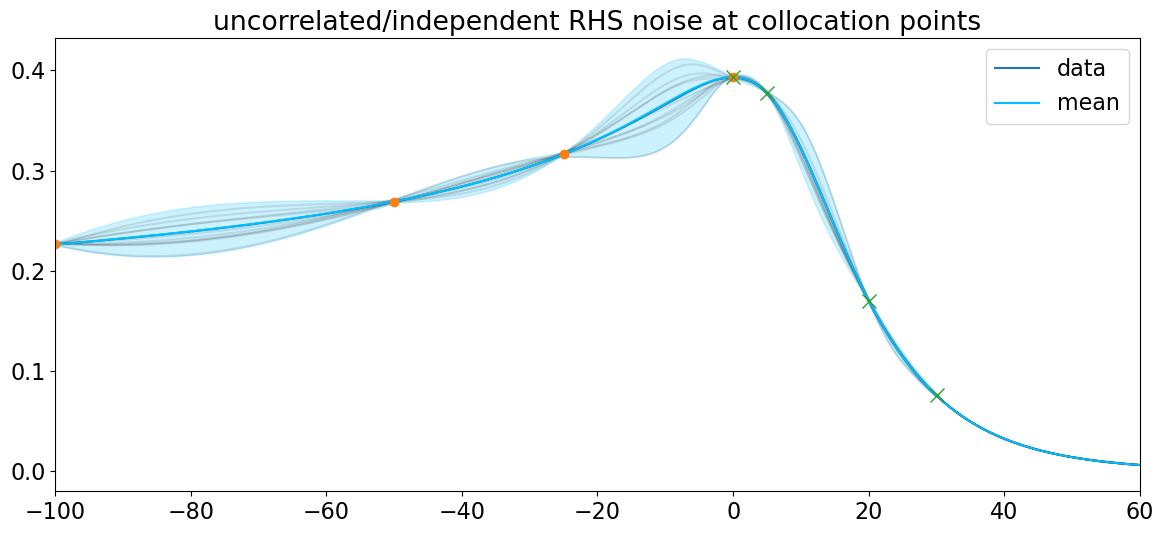

In [172]:
plt.figure(figsize=(14, 6), dpi=100)

n_samples=100
t_start=-100

noise_rd_sd = 0.001
noise_m_sd = 0.001

mask = target_wf.times>t_start
plt.plot(target_wf.times[mask], target_wf.amp[mask], label='data')

yhats=[]
for i in range(n_samples):

    noise_rd = np.random.normal(0, noise_rd_sd, size=amp_ringdown_model.n_coeffs)
    noise_m = np.random.normal(0, noise_m_sd, size=amp_merger_model.n_coeffs)
    # noise_m[:4] = np.random.normal(0, 0.002, size=len(amp_merger_model.c_points))
    
    
    
    that, yhat = mrd_model(target_wf.times[target_wf.times>t_start], amp_merger_model, amp_ringdown_model, noise_m=noise_m, noise_rd=noise_rd)
    yhats.append(yhat)
    
yhats = np.array(yhats)

for yhat in yhats[:10]:
    plt.plot(that, yhat, c='k', alpha=0.1)

plt.plot(that, yhats.mean(0), color='deepskyblue', label='mean')
plt.fill_between(that, y1=yhats.min(0), y2=yhats.max(0), alpha=0.2, color='deepskyblue')


plt.plot(amp_merger_model.c_points, amp_merger_model.predict(amp_merger_model.c_points), 'o')
plt.plot(amp_ringdown_model.c_points, amp_ringdown_model.predict(amp_ringdown_model.c_points), 'x', markersize=10)

# plt.yscale('log')
plt.xlim(-100, 60)
# plt.ylim(0.01, 0.22)

plt.legend()

plt.title("uncorrelated/independent RHS noise at collocation points")

Text(0.5, 1.0, 'correlated RHS noise at collocation points')

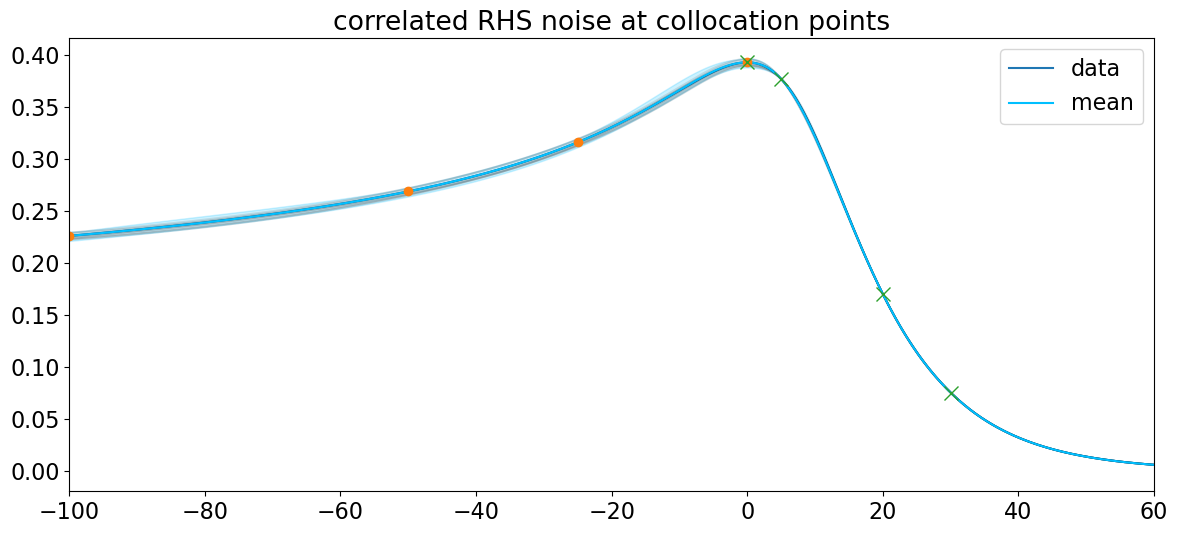

In [173]:
plt.figure(figsize=(14, 6), dpi=100)

n_samples=100
t_start=-100
noise_rd_sd = 0.0001
noise_m_sd = 0.0001

mask = target_wf.times>t_start
plt.plot(target_wf.times[mask], target_wf.amp[mask], label='data')

yhats=[]
for i in range(n_samples):

    noise_rd = np.random.normal(0, noise_rd_sd, size=amp_ringdown_model.n_coeffs)
    noise_m = np.random.normal(0, noise_m_sd, size=amp_merger_model.n_coeffs)
    noise_m[:4] = noise_m[0]*20
    
    # fix the noise at t=0 in both merger and ringdown models to be the same
    # to enforce continuity
    noise_rd[0] = noise_m[3]
    
    
    
    that, yhat = mrd_model(target_wf.times[target_wf.times>t_start], amp_merger_model, amp_ringdown_model, noise_m=noise_m, noise_rd=noise_rd)
    yhats.append(yhat)
    
yhats = np.array(yhats)

for yhat in yhats[:10]:
    plt.plot(that, yhat, c='k', alpha=0.1)

plt.plot(that, yhats.mean(0), color='deepskyblue', label='mean')
plt.fill_between(that, y1=yhats.min(0), y2=yhats.max(0), alpha=0.2, color='deepskyblue')


plt.plot(amp_merger_model.c_points, amp_merger_model.predict(amp_merger_model.c_points), 'o')
plt.plot(amp_ringdown_model.c_points, amp_ringdown_model.predict(amp_ringdown_model.c_points), 'x', markersize=10)

# plt.yscale('log')
plt.xlim(-100, 60)
# plt.ylim(0.01, 0.22)

plt.legend()

plt.title("correlated RHS noise at collocation points")

for dominant mode and non-precessing systems we have that the waveform data (up to the peak)
should be monotonic. This assumption can break in GPR and independent random noise sampling
of RHS noise.

This can be fixed in parametric 'probabilistic' models such as this but enforce RHS values at future points
to be monotonic. This does mean, unfortunately something like rejection sampling?

That's the correct way of doing things to have a heteroscedastic error.

We could assume a simple relationship as it's probably almost always true that the error grows with time
or we can treat the error as homoscedastic

# hacked together h(t) samples

In [ ]:
asc

In [174]:
# yhats_amp = yhats.copy()
# yhats_freq = yhats.copy()

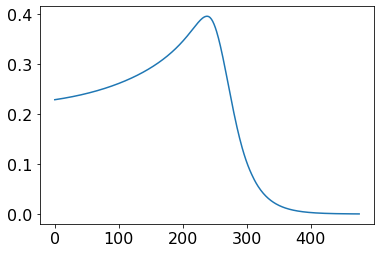

In [175]:
# plt.plot(yhats[0])

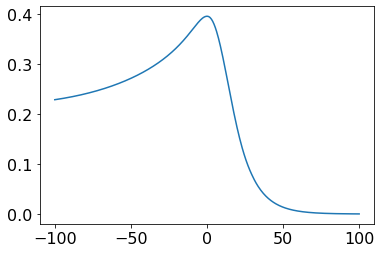

In [177]:
plt.plot(that, yhats_amp[0])

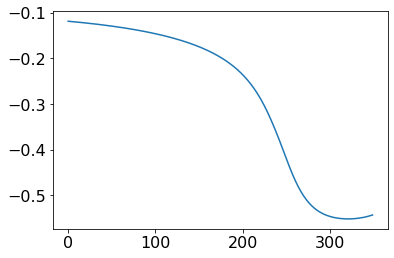

In [188]:
plt.plot(yhats_freq[0,:350])

In [189]:
i_yhats_freq = [IUS(that[:350], yhats_freq_[:350]) for yhats_freq_ in yhats_freq]

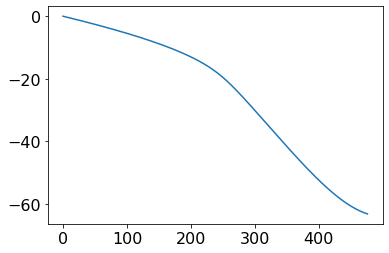

In [192]:
plt.plot(i_yhats_freq[0].antiderivative()(that))

In [193]:
hs = [yhats_amp[i] * np.exp(-1.j*i_yhats_freq[i].antiderivative()(that)) for i in range(len(yhats_freq))]

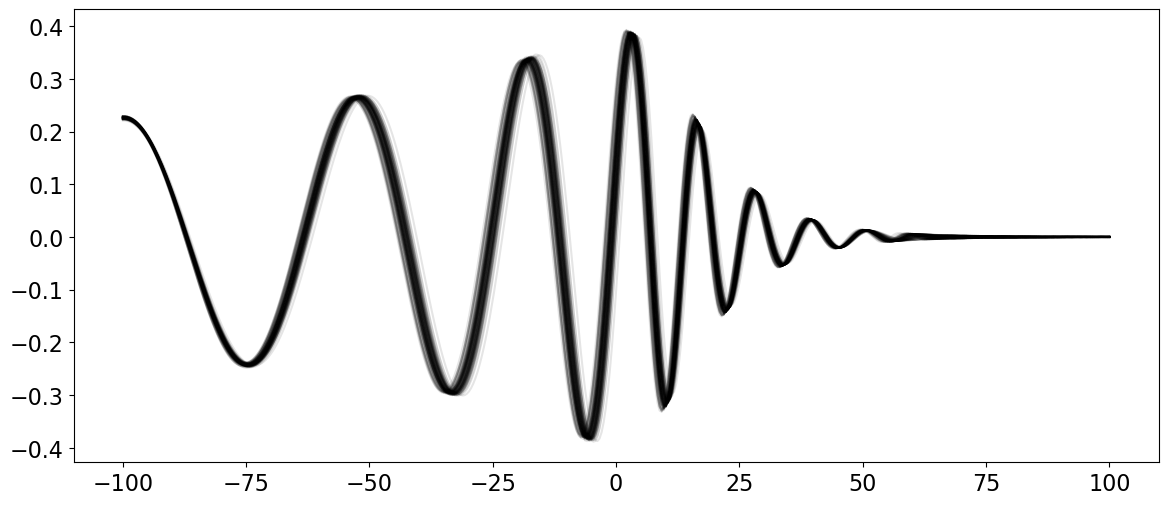

In [204]:
plt.figure(figsize=(14, 6), dpi=100)
for h in hs:
    plt.plot(that, h.real, c='k', alpha=0.1)